In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import pystan
import pandas as pd
import math
import datetime
from sklearn.metrics import mean_squared_error
import pandas
import seaborn

In [2]:
import os
os.chdir('D:\/Downloads-D')

In [3]:
dta = pd.read_csv('weekly_in_situ_co2_mlo.csv')

In [4]:
dta

,Date,Amt
0,3/29/1958,316.19
1,4/5/1958,317.31
2,4/12/1958,317.69
3,4/19/1958,317.58
4,4/26/1958,316.48
...,...,...
3194,10/31/2020,411.92
3195,11/7/2020,412.37
3196,11/14/2020,412.67
3197,11/21/2020,412.98


We split into a training set and a test set to test our model later. Training set has 90% of data

In [5]:
split = int(len(dta)*0.9)
dates = dta['Date'][:split]
amt = dta['Amt'][:split]
dates_test = dta['Date'][split:]
amt_test=dta['Amt'][split:]

In [6]:
#It is hard to graph with the dates being as they are, so I change them to days counting from the starting point (1958)
dates_modified = [pd.to_datetime(i) for i in dates]
dates_test_modified = [pd.to_datetime(i) for i in dates_test]
initial_point = min(dates_modified) #the very first day of the data
dates_modified = np.array(dates_modified) - np.array(initial_point)
dates_test_modified = np.array(dates_test_modified) - np.array(initial_point)
for i in range(len(dates_modified)):
    dates_modified[i] = int(str(dates_modified[i]).split(' ')[0])
for i in range(len(dates_test_modified)):
    dates_test_modified[i] = int(str(dates_test_modified[i]).split(' ')[0])

In [7]:
#Change the type of data to list to easily process later on
dates_modified  = list(dates_modified)
dates_test_modified  = list(dates_test_modified)

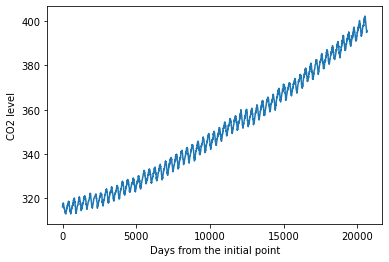

In [8]:
#Graphing the training data
plt.plot(dates_modified, amt)
plt.xlabel("Days from the initial point")
plt.ylabel("CO2 level")
plt.show()

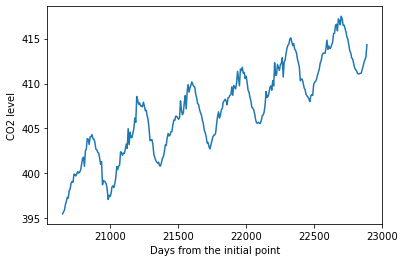

In [9]:
#Visualizing the test data
plt.plot(dates_test_modified, amt_test)
plt.xlabel("Days from the initial point")
plt.ylabel("CO2 level")
plt.show()

## Trend analysis

We consider two different models: the linear and the quadratic model

Linear model: Has the form N(x|c_0 + c_1*t, sigma)

In [10]:
data_stan = {
    'observation_num': len(dates_modified),
    'date': dates_modified,
    'co2': amt
}

In [11]:
#Stan model - reusing the code from class activity with appropriate adjustments

linear_model = """

// The data block contains all known quantities - typically the observed data and any constant hyperparameters.
data {
    int<lower=0> observation_num;  // number of data points in the training dataset 
    int<lower=0> date[observation_num];  // number of days after the initial point 
    real<lower=0> co2[observation_num];  // co2 measurement
}

// The parameters block contains all unknown quantities - typically the parameters of the model. 
parameters {
    real<lower=0> c0;  // parameter in linear model - justifications in the report
    real<lower=0> c1;   //parameter in linear model 
    real<lower=0> sigma;   // variance of the distribution
}

// The model block contains all probability distributions in the model.
model {
    //Hyperpriors 
    c0 ~ normal(315, 1); //Justifications in the report
    c1 ~ normal(0.005, 0.001); //
    sigma ~ normal(1,0.5); //
    
    //Likelihood   
    for (i in 1:observation_num) {
        co2[i] ~ normal(c0+c1*date[i], sigma);  
    }
}

"""

linear_mod = pystan.StanModel(model_code = linear_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b99b3a5c4440b8fc581597554d30fdaf NOW.


In [12]:
result_linear = linear_mod.sampling(data = data_stan)
print(result_linear.stansummary())

Inference for Stan model: anon_model_b99b3a5c4440b8fc581597554d30fdaf.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0    307.67  3.2e-3   0.13 307.41 307.58 307.67 307.76 307.92   1663    1.0
c1    4.1e-3  2.8e-7 1.1e-5 4.1e-3 4.1e-3 4.1e-3 4.1e-3 4.1e-3   1517    1.0
sigma   3.62  1.2e-3   0.05   3.53   3.59   3.62   3.65   3.71   1450    1.0
lp__   -5199    0.03   1.16  -5202  -5200  -5199  -5198  -5198   1281    1.0

Samples were drawn using NUTS at Wed Dec 16 14:14:56 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Mean squared error is 13.24368898146253


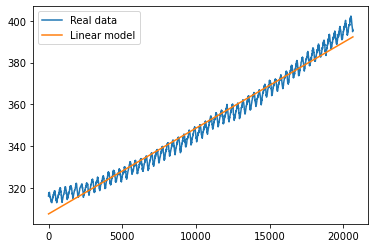

In [13]:
#Examine fit on the training data
sample_linear = result_linear.extract()
temp = []
for i in range(len(dates_modified)):
    temp.append(dates_modified[i]*np.mean(sample_linear['c1']))
linear_pred = np.mean(sample_linear['c0']) + temp
mse = mean_squared_error(amt, linear_pred)
print("Mean squared error is", mse)
plt.figure()
plt.plot(dates_modified, amt, label = 'Real data')
plt.plot(dates_modified, linear_pred, label = 'Linear model')
plt.legend()
plt.show()


Now we consider the quadratic model which has the form N(x|c_0 + c_1*t + c_2*t^2, sigma)

In [62]:
#Stan model - reusing the code from class activity with appropriate adjustments

quadratic_model = """

// The data block contains all known quantities - typically the observed data and any constant hyperparameters.
data {
    int<lower=0> observation_num;  // number of data points in the training dataset 
    int<lower=0> date[observation_num];  // number of days after the initial point 
    real<lower=0> co2[observation_num];  // co2 measurement
}

// The parameters block contains all unknown quantities - typically the parameters of the model. 
parameters {
    real<lower=0> c0;  // parameter in quadratic model - justifications in the report
    real c1;   //parameter in quadratic model 
    real<lower=0> c2; //parameter in quadratic model
    real<lower=0> sigma;   //unknown variance of the distribution
}

// The model block contains all probability distributions in the model.
model {
    //Hyperpriors 
    c0 ~ normal(315, 1); // Justifications in the report
    c1 ~ normal(0.005, 0.001); //
    c2 ~ normal(0.00000005, 0.0000001); //
    sigma ~ normal(1,0.5); //
    
    //Likelihood   
    for (i in 1:observation_num) {
        co2[i] ~ normal(c0+c1*date[i]+c2*(date[i]^2), sigma);  
    }
}

"""

quadratic_mod = pystan.StanModel(model_code = quadratic_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c1199d88e674803b51ee8e002de29a9a NOW.


In [63]:
result_quadratic = quadratic_mod.sampling(data = data_stan)
print(result_quadratic.stansummary())

Inference for Stan model: anon_model_c1199d88e674803b51ee8e002de29a9a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0     314.3  4.8e-3   0.13 314.04 314.21  314.3 314.39 314.55    786    1.0
c1    2.2e-3  9.9e-7 2.9e-5 2.1e-3 2.2e-3 2.2e-3 2.2e-3 2.3e-3    876    1.0
c2    9.2e-8 4.2e-11 1.4e-9 8.9e-8 9.1e-8 9.2e-8 9.3e-8 9.5e-8   1020    1.0
sigma   2.21  7.0e-4   0.03   2.15   2.19   2.21   2.23   2.27   1845    1.0
lp__   -3747    0.05   1.46  -3751  -3748  -3747  -3746  -3745    759   1.01

Samples were drawn using NUTS at Wed Dec 16 21:49:49 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Mean squared error is 4.904647406763101


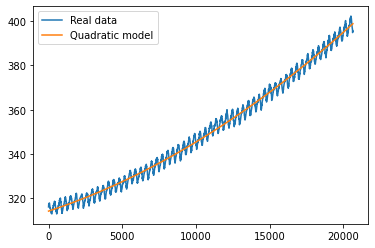

In [64]:
#Examine fit on the training data
sample_quadratic = result_quadratic.extract()
temp = []
for i in range(len(dates_modified)):
    temp.append(dates_modified[i]*np.mean(sample_quadratic['c1'])+(dates_modified[i]**2)*np.mean(sample_quadratic['c2']))
quadratic_pred = np.mean(sample_quadratic['c0']) + temp
mse_quad = mean_squared_error(amt, quadratic_pred)
print("Mean squared error is", mse_quad)
plt.figure()
plt.plot(dates_modified, amt, label = 'Real data')
plt.plot(dates_modified, quadratic_pred, label = 'Quadratic model')
plt.legend()
plt.show()


## Seasonality analysis

From the report, we have concluded that the waves are not symmetrical - the descend is faster than the ascend.

In [17]:
#Based on code from class and from https://stackoverflow.com/questions/41904923/closed-form-expression-for-an-asymmetric-triangle-wave/41906140#41906140
def seasonality(x, phase, period, amin, amax, rising_time):    
    '''
    Find the seasonality factor in the model
    
    Inputs:
        x: date values at which to evaluate seasonality
        period: the length of time of a wave
        phase: phase of the variation (negative phase shifts the wave to the left, positive to the right)
        amin, amax: derived from the amplitude A. amax = A, amin = -A
        rising_time: the amount of time in a period accounted for by the ascend
    Output:
        y: value of the seasonality factor
    '''
    period_until_change = (x - phase)% period  
    if period_until_change <= rising_time:
        y = amin + (amax - amin) * (period_until_change / rising_time) #refer to the report for details
    else:
        y = amax -  (amax - amin) * (period_until_change - rising_time) / (period - rising_time)
    return y

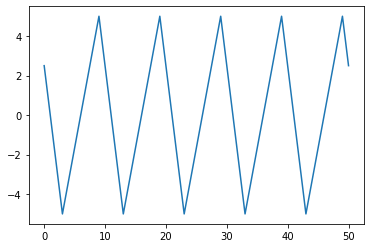

In [18]:
#An example
x_axis = np.linspace(0, 50, 51)
y_axis = []
for i in x_axis:
    y_axis.append(seasonality(i, 3, 10,-5, 5, 6))
#To make the descend faster than the ascend we simply make the rising_time to be more than half of the period
plt.plot(x_axis, y_axis)

## Full model

Parameters: c0, c1, c2, phase, amplitude, rising_time, and sigma.
Others: T= 365.25

In [19]:
#Stan model - reusing the code from class activity with appropriate adjustments

full_model = """

// The data block contains all known quantities - typically the observed data and any constant hyperparameters.
data {
    int<lower=0> observation_num;  // number of data points in the training dataset 
    int<lower=0> date[observation_num];  // number of days after the initial point 
    real<lower=0> co2[observation_num];  // co2 measurement
}

// The parameters block contains all unknown quantities - typically the parameters of the model. 
parameters {
    real<lower=0> c0;  // parameter in quadratic model - Justifications in the report
    real c1;   //parameter in quadratic model 
    real<lower=0> c2; //parameter in quadratic model
    real<lower=0, upper = 365.25> phase; //Parameter in the seasonality function
    real<lower=0> amplitude; //Parameter in the seasonality function
    real<lower=0, upper = 365.25> rising_time; //Parameter in the seasonality function
    real<lower=0> sigma;   //unknown variance of the distribution
}

// The model block contains all probability distributions in the model.
model {
    real period_until_change; //extra variables to implement the seasonality function below
    real seasonality;
    //Hyperpriors 
    c0 ~ normal(320, 5); //Justifications in the report
    c1 ~ normal(0.005, 0.001); //
    c2 ~ normal(0.0000005, 0.0000001); //
    phase ~ normal(182, 20);
    amplitude ~ normal(4, 1);
    rising_time ~ normal(250, 10);
    sigma ~ normal(1,0.5); //
    
    //Likelihood   
    for (i in 1:observation_num) {
        period_until_change = fmod(date[i]-phase, 365.25);
        seasonality = (period_until_change<=rising_time ? -amplitude : amplitude) + (period_until_change<=rising_time ? 2 : -2)*amplitude*(fmod(date[i]-phase,365.25)-(period_until_change<=rising_time ? 0 : rising_time))/(period_until_change<=rising_time ? (rising_time) : (365.25-rising_time));
        co2[i] ~ normal(c0+c1*date[i]+c2*(date[i]^2)+seasonality, sigma);
        
    }
}

"""

full_mod = pystan.StanModel(model_code = full_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_09c3a7b19d0123b5129d93ab543d4825 NOW.


In [20]:
result_full = full_mod.sampling(data = data_stan)
print(result_full.stansummary())

Inference for Stan model: anon_model_09c3a7b19d0123b5129d93ab543d4825.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean      sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0          314.66  1.9e-3    0.06 314.55 314.62 314.66  314.7 314.77    916   1.01
c1          2.1e-3  4.5e-7  1.3e-5 2.1e-3 2.1e-3 2.1e-3 2.1e-3 2.2e-3    800   1.01
c2          9.4e-8 2.1e-11 5.9e-10 9.3e-8 9.4e-8 9.4e-8 9.5e-8 9.5e-8    814   1.01
phase       172.86    0.08    1.01 170.81 172.18 172.88 173.55 174.72    172   1.01
amplitude     3.33    0.03    0.22   3.29   3.33   3.35   3.38   3.42     73   1.04
rising_time 253.57    0.16     1.9 250.01 252.18 253.55 254.84 257.58    140   1.01
sigma         0.99  7.3e-3    0.06   0.96   0.98   0.99    1.0   1.02     78   1.03
lp__         -1431    16.9  139.62  -1423  -1418  -1417  -1416  -1415     68   1.04

Samples were drawn using NUTS at Wed Dec 16 14:35:52 2

In [21]:
#Examine fit on the training data
sample_full = result_full.extract()
full_pred_train=np.zeros((4000, len(dates_modified)))
for j in range(4000):
    for i in range(len(dates_modified)):
        trend = sample_full['c0'][j]+dates_modified[i]*sample_full['c1'][j]+(
            dates_modified[i]**2)*sample_full['c2'][j]
        season = seasonality(dates_modified[i], sample_full['phase'][j],365.25,
                             sample_full['amplitude'][j]*-1, sample_full['amplitude'][j], sample_full['rising_time'][j])
        mean_full = trend+season
        sample = sts.norm(mean_full, sample_full['sigma'][j]).rvs()
        full_pred_train[j,i] = sample

Mean squared error is 0.6408215417983166


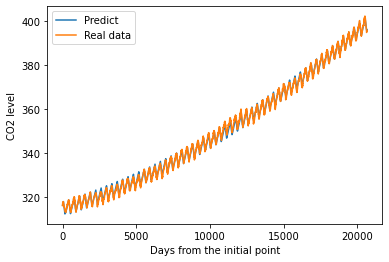

In [22]:
plt.figure()
plt.plot(dates_modified, np.mean(full_pred_train, axis=0), label='Predict')
plt.plot(dates_modified, amt, label='Real data')
print("Mean squared error is",mean_squared_error(amt, np.mean(full_pred_train, axis=0)))
plt.legend()
plt.xlabel("Days from the initial point")
plt.ylabel("CO2 level")
plt.show()

We see from the graph above that the fit is quite good

In [23]:
def plot_acf(x): #reuse code from class for the autocorrelation plot
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    The autocorrelation at lag = 0 is always 1 since the series is perfectly
    correlated with itself. You can ignore this value. The autocorrelation at
    all other values should be as small as possible, since independent samples
    have no correlation.
    '''
    from scipy import signal
    import matplotlib.pyplot as plt
    plt.acorr(
    x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))

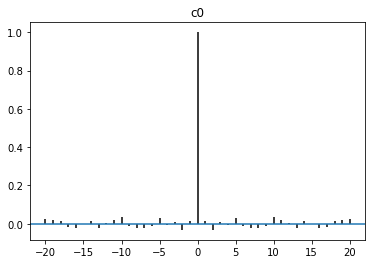

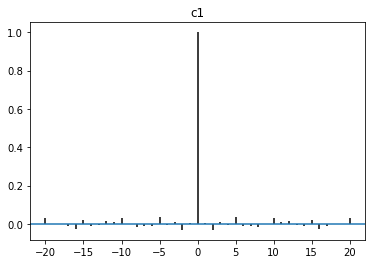

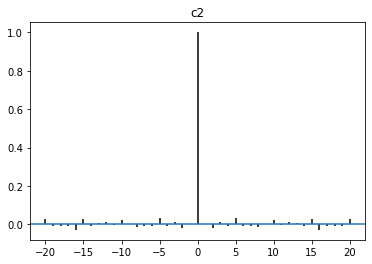

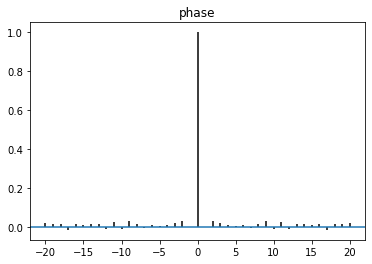

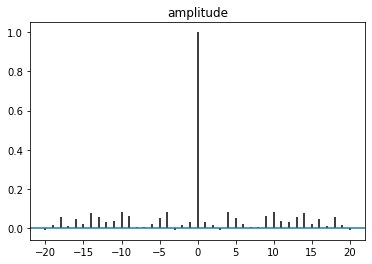

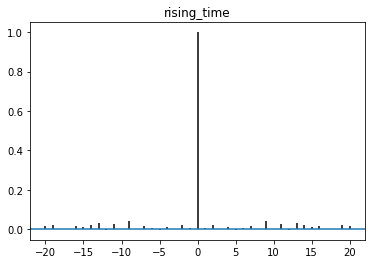

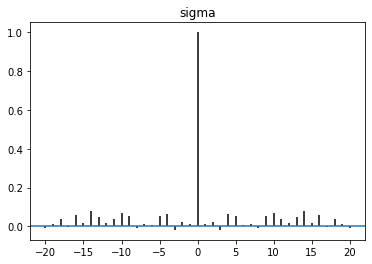

In [24]:
#Autocorrelation plots
list_param  = ['c0','c1','c2','phase','amplitude','rising_time','sigma']
for i in list_param:
    plt.figure()
    plot_acf(sample_full[i])
    plt.title(i)

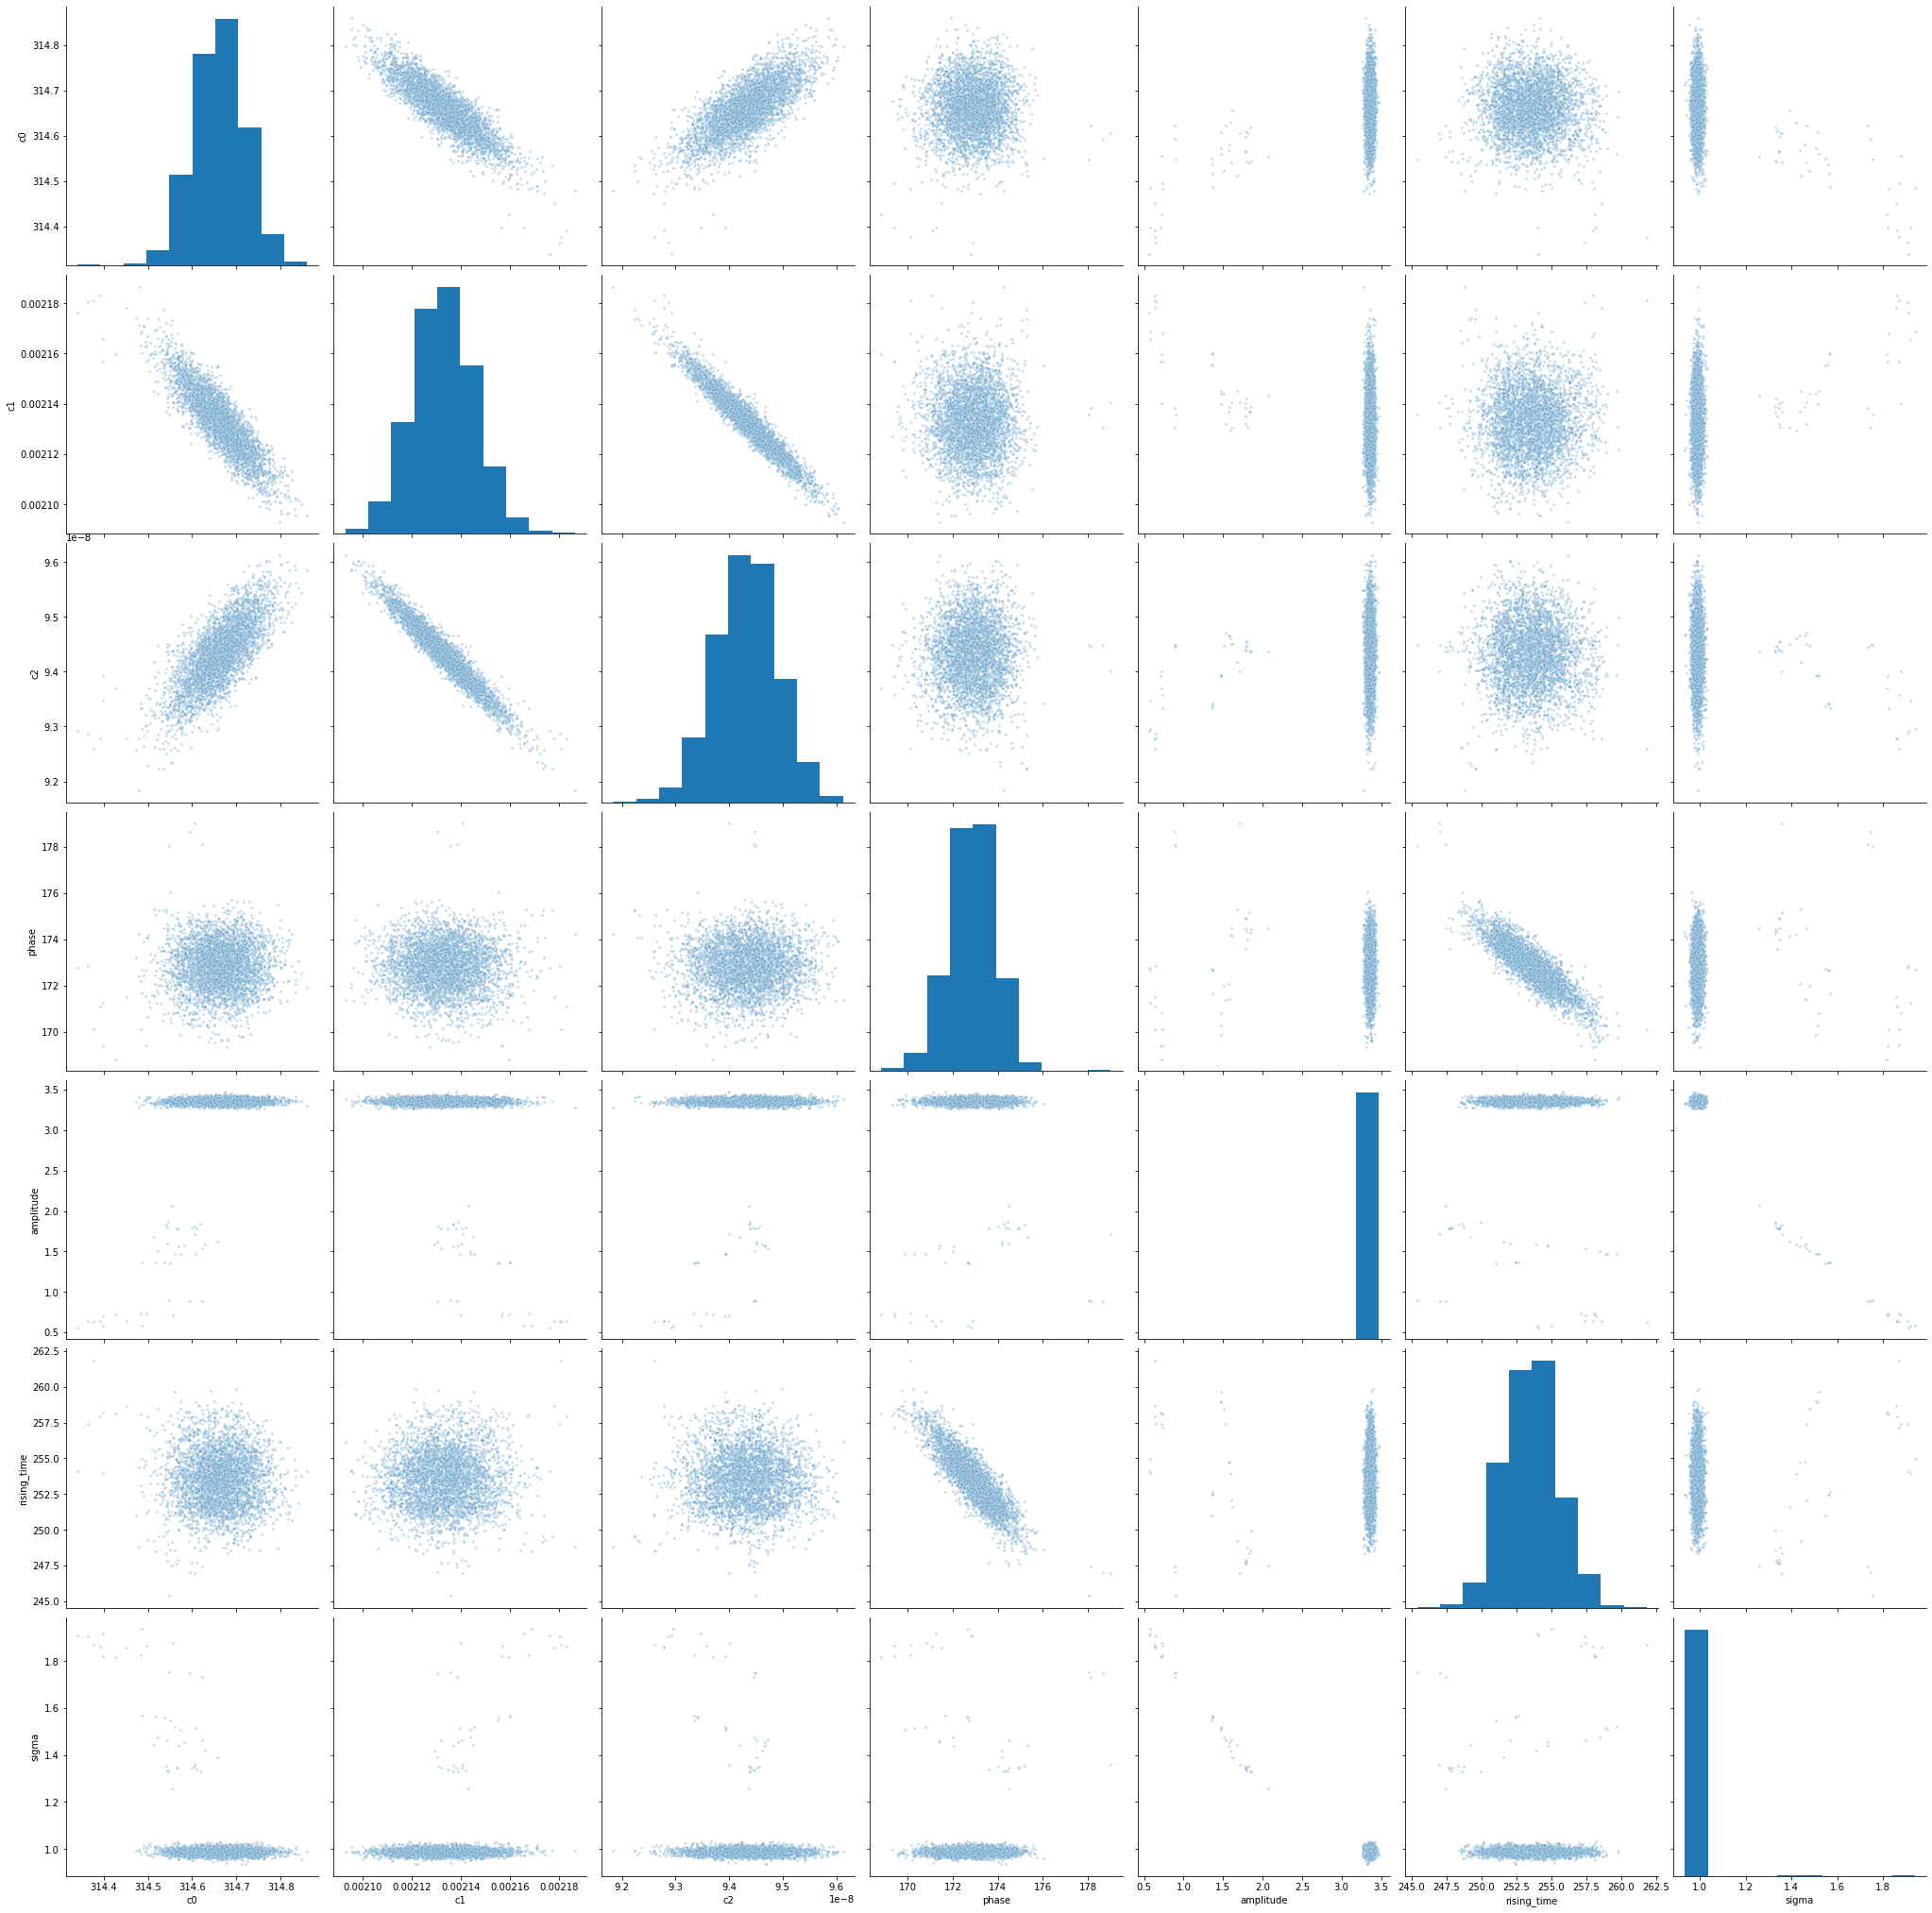

In [25]:
# Make pair plot of the posteriors over all parameters of the model.
df = pandas.DataFrame(
    data=np.transpose([sample_full[param] for param in list_param]),
    columns=list_param)
seaborn.pairplot(df, height=4, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

## Building the given model (linear trend, cosine seasonality) for comparison

In [26]:
#Stan model - reusing the code from class activity with appropriate adjustments

given_model = """

// The data block contains all known quantities - typically the observed data and any constant hyperparameters.
data {
    int<lower=0> observation_num;  // number of data points in the training dataset 
    int<lower=0> date[observation_num];  // number of days after the initial point 
    real<lower=0> co2[observation_num];  // co2 measurement
}

// The parameters block contains all unknown quantities - typically the parameters of the model. 
parameters {
    real<lower=0> c0;  // parameter in linear model
    real<lower=0> c1;   //parameter in linear model 
    real<lower=0> c2; //parameter seasonality function - this is the amplitude
    real<lower=0, upper=pi()> c3; //Parameter in the seasonality function - this is 
    real<lower=0> sigma;   //unknown variance of the distribution
}

// The model block contains all probability distributions in the model.
model {
    real seasonality; //extra variables to implement the seasonality function below;
    //Hyperpriors 
    c0 ~ normal(320, 5); //Justifications in the report
    c1 ~ normal(0.005, 0.001); //
    c2 ~ normal(4,1); //
    c3 ~ normal(pi()/2, pi()/4);
    sigma ~ normal(1,0.5); //
    
    //Likelihood   
    for (i in 1:observation_num) {
        seasonality = c2*cos(2*pi()*date[i]/365.25 + c3);
        co2[i] ~ normal(c0+c1*date[i]+seasonality, sigma);
        
    }
}

"""

given_mod = pystan.StanModel(model_code = given_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_faeea7a6c7fcdf7da54a7241e4ba8921 NOW.


In [27]:
result_given = given_mod.sampling(data = data_stan)
print(result_given.stansummary())

Inference for Stan model: anon_model_faeea7a6c7fcdf7da54a7241e4ba8921.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0    307.54  2.0e-3   0.12 307.31 307.46 307.55 307.63 307.79   3746    1.0
c1    4.1e-3  1.7e-7 1.0e-5 4.1e-3 4.1e-3 4.1e-3 4.1e-3 4.1e-3   3679    1.0
c2       2.6  1.7e-3   0.08   2.44   2.55    2.6   2.66   2.76   2294    1.0
c3    2.1e-3  4.1e-5 2.1e-3 5.9e-5 5.9e-4 1.4e-3 2.9e-3 8.0e-3   2732    1.0
sigma   3.13  8.3e-4   0.04   3.05    3.1   3.13   3.16   3.21   2465    1.0
lp__   -4759    0.04   1.62  -4763  -4760  -4759  -4758  -4757   1661    1.0

Samples were drawn using NUTS at Wed Dec 16 17:59:48 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [28]:
#Examine fit of the given model on the test data
sample_given = result_given.extract()
given_pred=np.zeros((4000, len(dates_test_modified)))
for j in range(4000):
    for i in range(len(dates_test_modified)):
        trend = sample_given['c0'][j]+dates_test_modified[i]*sample_given['c1'][j]
        season = sample_given['c2'][j]*np.cos(2*math.pi*dates_test_modified[i]/365.25 + sample_given['c3'][j])
        mean_full = trend+season
        sample = sts.norm(mean_full, sample_given['sigma'][j]).rvs()
        given_pred[j,i] = sample
        

#mse_full = mean_squared_error(amt_test, full_pred)
#print("Mean squared error is", mse_full)
#plt.figure()
#plt.plot(dates_test_modified, amt_test, label = 'Real data')
#plt.plot(dates_test_modified, full_pred, label = 'Full model')
#plt.legend()
#plt.show()


Mean squared error is 108.83478750474254


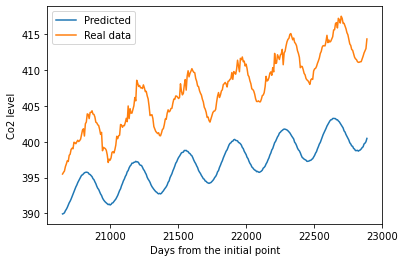

In [29]:
#Plotting the fit
plt.figure()
plt.plot(dates_test_modified, np.mean(given_pred, axis=0), label='Predicted')
plt.plot(dates_test_modified, amt_test, label='Real data')
print("Mean squared error is", mean_squared_error(amt_test, np.mean(given_pred,axis=0)))
plt.xlabel("Days from the initial point")
plt.ylabel("Co2 level")
plt.legend()
plt.show()

#### Compared with the model we proposed

In [30]:
#Examine fit of the proposed (improved) model on the test data
sample_full = result_full.extract()
full_pred=np.zeros((4000, len(dates_test_modified)))
for j in range(4000):
    for i in range(len(dates_test_modified)):
        trend = sample_full['c0'][j]+dates_test_modified[i]*sample_full['c1'][j]+(
            dates_test_modified[i]**2)*sample_full['c2'][j] 
        season = seasonality(dates_test_modified[i], sample_full['phase'][j],365.25,
                             sample_full['amplitude'][j]*-1, sample_full['amplitude'][j], sample_full['rising_time'][j])
        mean_full = trend+season #full mean of the model: the trend factor plus the seasonality factor
        sample = sts.norm(mean_full, sample_full['sigma'][j]).rvs()
        full_pred[j,i] = sample

Mean squared error is 2.667405805592478


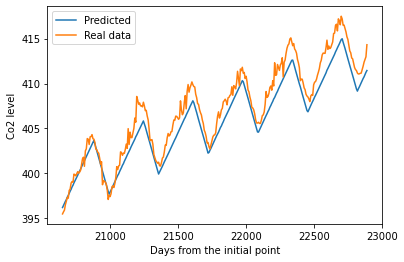

In [31]:
#Plotting the model predictions on the test data
plt.figure()
plt.plot(dates_test_modified, np.mean(full_pred, axis=0), label='Predicted')
plt.plot(dates_test_modified, amt_test, label='Real data')
print("Mean squared error is", mean_squared_error(amt_test, np.mean(full_pred,axis=0)))
plt.xlabel("Days from the initial point")
plt.ylabel("Co2 level")
plt.legend()
plt.show()

We see that the fit is much better.

## Predict data in the next 40 years

In [32]:
#Predict
#finding the final date that we want to predict
ending_date = int(dates_test_modified[-1] + 365.25*40) 
#Create the dates for prediction
x_pred = list(range(int(dates_test_modified[-1]), ending_date, 7))
sample_full = result_full.extract()
full_pred_future=np.zeros((4000, len(x_pred)))
for j in range(4000):
    for i in range(len(x_pred)):
        trend = sample_full['c0'][j]+x_pred[i]*sample_full['c1'][j]+(
            x_pred[i]**2)*sample_full['c2'][j]
        season = seasonality(x_pred[i], sample_full['phase'][j],365.25,
                             sample_full['amplitude'][j]*-1, sample_full['amplitude'][j], sample_full['rising_time'][j])
        mean_full = trend+season
        sample = sts.norm(mean_full, sample_full['sigma'][j]).rvs()
        full_pred_future[j,i] = sample

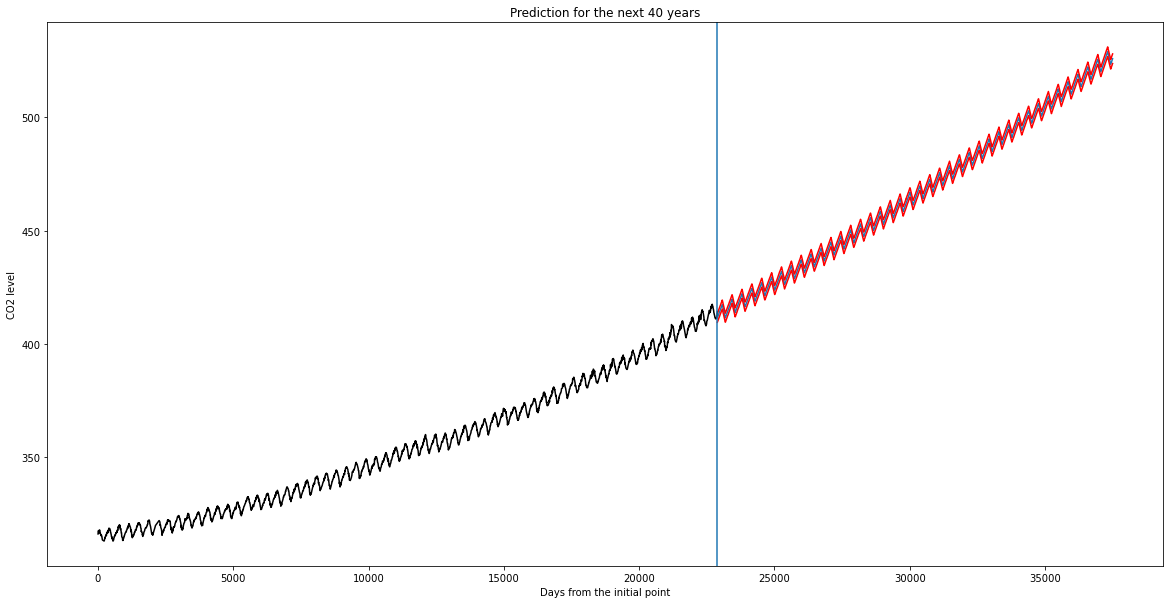

In [33]:
#Find the confidence intervals
upper = np.percentile(full_pred_future, 97.5, axis=0)
lower = np.percentile(full_pred_future, 2.5, axis=0)
plt.figure(figsize=(20, 10))
plt.plot(x_pred, np.mean(full_pred_future, axis=0))
plt.plot(x_pred, upper, color='red')
plt.plot(x_pred, lower, color='red')
plt.plot(dates_modified, amt, color='black')
plt.plot(dates_test_modified, amt_test, color='black')
plt.xlabel("Days from the initial point")
plt.ylabel("CO2 level")
plt.title("Prediction for the next 40 years")
plt.axvline(dates_test_modified[-1])
plt.show()

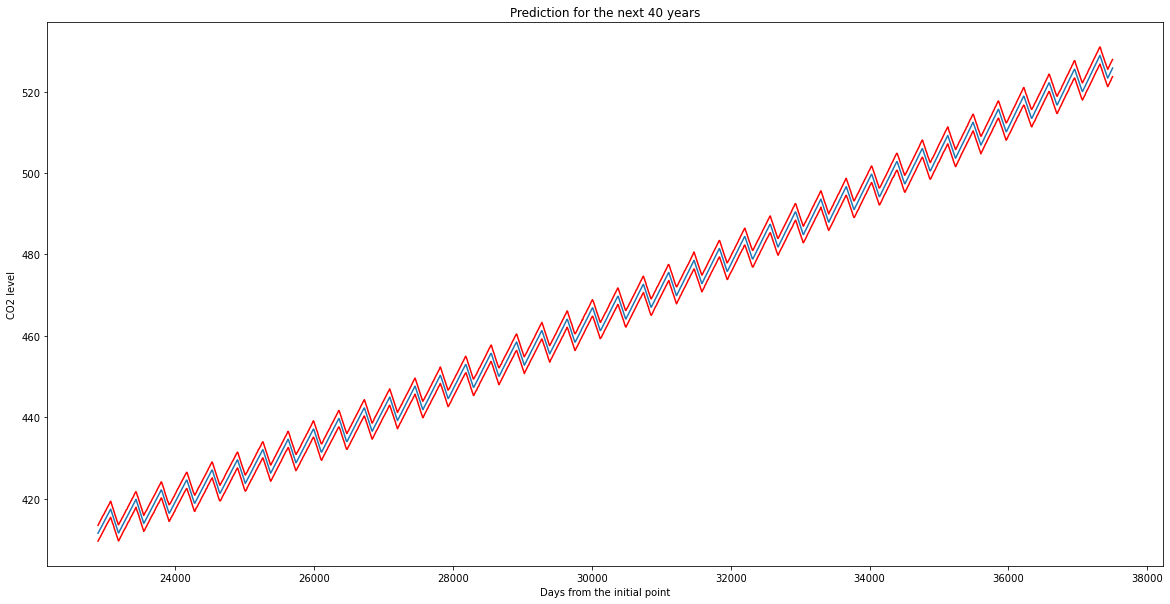

In [34]:
plt.figure(figsize=(20, 10))
plt.plot(x_pred, np.mean(full_pred_future, axis=0))
plt.plot(x_pred, upper, color='red')
plt.plot(x_pred, lower, color='red')
plt.xlabel("Days from the initial point")
plt.ylabel("CO2 level")
plt.title("Prediction for the next 40 years")
plt.show()

In [35]:
print("Estimate of expected CO2 level in 2060 is", np.mean(full_pred_future, axis=0)[-1])
print("Confidence intervals of CO2 level in 2060 is", [lower[-1], upper[-1]])

Estimate of expected CO2 level in 2060 is 525.8067352357162
Confidence intervals of CO2 level in 2060 is [523.6787137822658, 527.9108355382378]


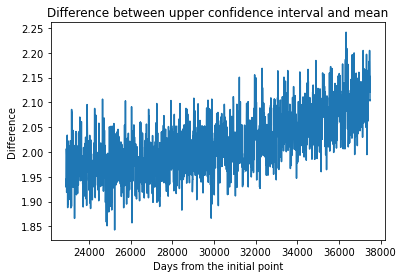

In [36]:
#Examine the width of confidence intervals
dif_upper = upper - list(np.mean(full_pred_future, axis=0))
dif_lower = lower - list(np.mean(full_pred_future, axis=0))
plt.plot(x_pred, dif_upper)
plt.title("Difference between upper confidence interval and mean")
plt.xlabel("Days from the initial point")
plt.ylabel("Difference")
plt.show()

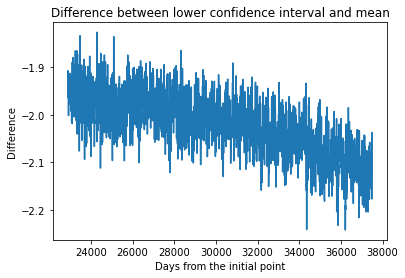

In [37]:
plt.plot(x_pred, dif_lower)
plt.title("Difference between lower confidence interval and mean")
plt.xlabel("Days from the initial point")
plt.ylabel("Difference")
plt.show()

## Examine when the dangerous CO2 threshold will be breached

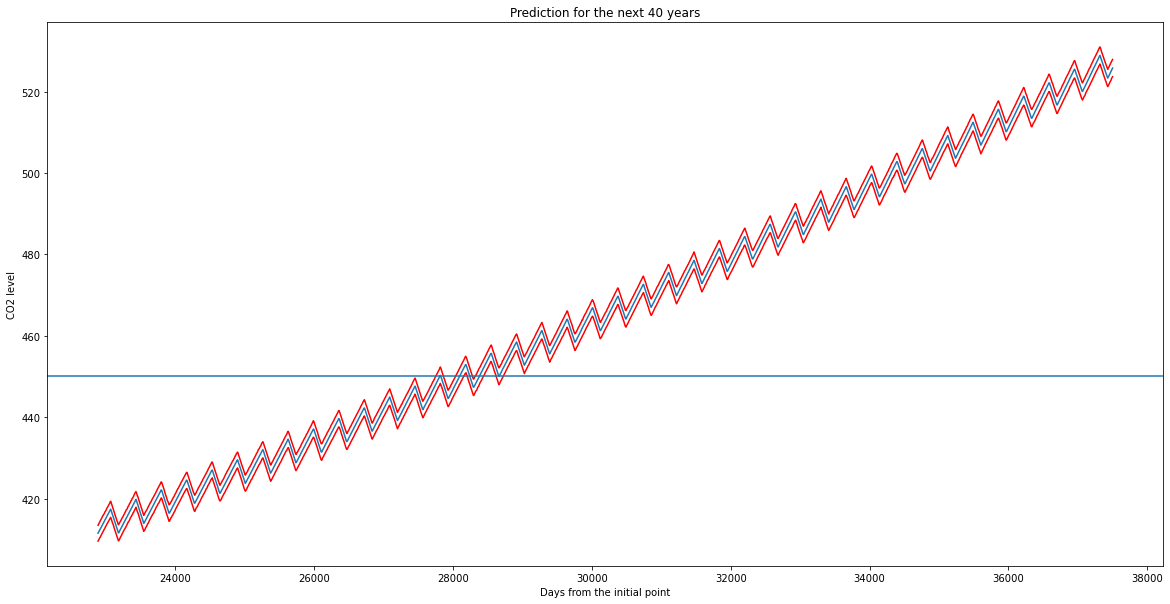

In [38]:
#The dangerous CO2 threshold is 450ppm
plt.figure(figsize=(20, 10))
plt.plot(x_pred, np.mean(full_pred_future, axis=0))
plt.plot(x_pred, upper, color='red')
plt.plot(x_pred, lower, color='red')
plt.axhline(450)
plt.xlabel("Days from the initial point")
plt.ylabel("CO2 level")
plt.title("Prediction for the next 40 years")
plt.show()

In [39]:
def day_calculator(day):
    '''
    Function to convert number of days after the initial point to the actual date
    
    input (int): number of days after the initial point
    
    output: corresponding date
    '''
    initial_point = datetime.datetime.strptime('1958-03-29', "%Y-%m-%d")
    date = initial_point + datetime.timedelta(days=int(day))
    return date.strftime("%B %d, %Y")

In [40]:
#Determine from the graph above when exactly did the upper confint, lower confint and the mean touched the line
date_mean=[]
date_upper=[]
date_lower=[]
for i in range(len(upper)):
    if np.mean(full_pred_future, axis=0)[i] >= 450:
        date_mean.append(x_pred[i])
    if upper[i] >= 450:
        date_upper.append(x_pred[i])
    if lower[i] >= 450:
        date_lower.append(x_pred[i])

In [41]:
print("We breach 450ppm with 2.5% probability on", day_calculator(date_upper[0]))
print("We breach 450ppm with 50% probability on", day_calculator(date_mean[0]))
print("We breach 450ppm with 97.5% probability on", day_calculator(date_lower[0]))

We breach 450ppm with 2.5% probability on March 25, 2034
We breach 450ppm with 50% probability on May 20, 2034
We breach 450ppm with 97.5% probability on May 05, 2035


In [42]:
#We can also examine with other probabilities of breaching the threshold, say, 80%:
list_80 = np.percentile(full_pred_future, 20, axis=0)
date_80=[]
for i in range(len(upper)):
    if list_80[i] >= 450:
        date_80.append(x_pred[i])
print("We breach 450ppm with 80% probability on", day_calculator(date_80[0]))

We breach 450ppm with 80% probability on March 31, 2035


We see that the above numbers are not too far apart, so we can be fairly sure that the CO2 level is predicted to be breached by early 2034 to early 2035.

## Analyze model uncertainty using test statistics

In [43]:
#Using mean and standard deviation as test statistics - see the report for more details

In [44]:
mean_observed = np.mean(amt_test) #the observed mean
mean_pred = np.mean(full_pred, axis=1) #the distribution of predicted means

p value is 0.0


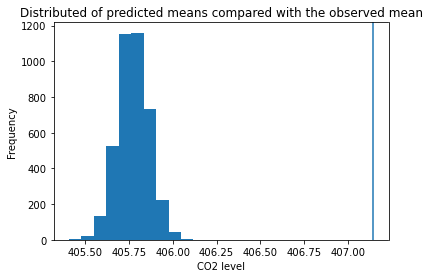

In [45]:
plt.figure()
plt.hist(mean_pred)
plt.axvline(mean_observed)
print('p value is',sum(mean_pred > mean_observed)/len(mean_pred))
plt.title("Distributed of predicted means compared with the observed mean")
plt.xlabel("CO2 level")
plt.ylabel("Frequency")
plt.show()

In [46]:
std_observed = np.std(amt_test) #The observed standard deviation
std_pred = np.std(full_pred, axis=1) #the distribution of predicted standard deviations

p value is 0.0


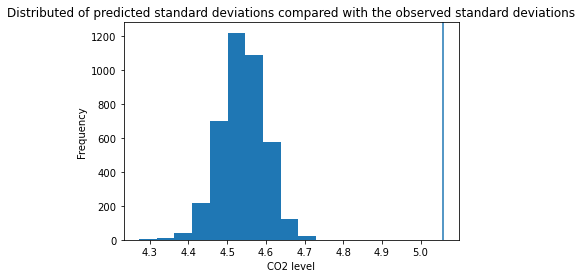

In [47]:
plt.figure()
plt.hist(std_pred)
plt.axvline(std_observed)
print('p value is',sum(std_pred > std_observed)/len(std_pred))
plt.title("Distributed of predicted standard deviations compared with the observed standard deviations")
plt.xlabel("CO2 level")
plt.ylabel("Frequency")
plt.show()